In [1]:
import torch

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device
     

'cpu'

In [2]:
from sklearn.datasets import make_moons

NUM_SAMPLES = 1000
RANDOM_SEED = 42

X, y = make_moons(n_samples=NUM_SAMPLES,
                  noise=0.07,
                  random_state=RANDOM_SEED)

X[:10], y[:10]

(array([[-0.03341062,  0.4213911 ],
        [ 0.99882703, -0.4428903 ],
        [ 0.88959204, -0.32784256],
        [ 0.34195829, -0.41768975],
        [-0.83853099,  0.53237483],
        [ 0.59906425, -0.28977331],
        [ 0.29009023, -0.2046885 ],
        [-0.03826868,  0.45942924],
        [ 1.61377123, -0.2939697 ],
        [ 0.693337  ,  0.82781911]]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]))

In [3]:
# Turn data into a DataFrame
import pandas as pd
data_df = pd.DataFrame({"X0": X[:, 0],
                        "X1": X[:, 1],
                        "y": y})
data_df.head()

,X0,X1,y
0,-0.033411,0.421391,1
1,0.998827,-0.442890,1
2,0.889592,-0.327843,1
3,0.341958,-0.417690,1
4,-0.838531,0.532375,0


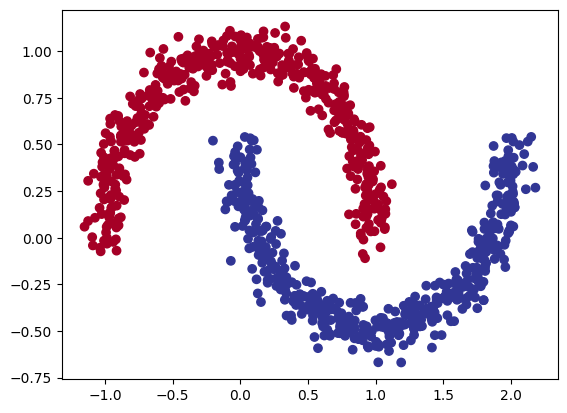

In [4]:
# Visualize the data on a plot
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [5]:
# Turn data into tensors
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

# Split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_SEED)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [6]:
import torch
from torch import nn

class MoonModelV0(nn.Module):
    def __init__(self, in_features, out_features, hidden_units):
        super().__init__()
        
        self.layer1 = nn.Linear(in_features=in_features, 
                                 out_features=hidden_units)
        self.layer2 = nn.Linear(in_features=hidden_units, 
                                 out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units,
                                out_features=out_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_0 = MoonModelV0(in_features=2,
                      out_features=1,
                      hidden_units=10).to(device)
model_0

MoonModelV0(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [7]:
model_0.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.6115,  0.2357],
                      [-0.0013,  0.2906],
                      [-0.1322, -0.4684],
                      [-0.5845,  0.1768],
                      [-0.0404,  0.2172],
                      [-0.7048,  0.1326],
                      [-0.1181,  0.2326],
                      [ 0.1763,  0.2917],
                      [-0.3361,  0.2187],
                      [ 0.5577, -0.0594]])),
             ('layer1.bias',
              tensor([-0.3146, -0.6169,  0.6080, -0.1055, -0.2358, -0.1764, -0.4136, -0.0483,
                       0.3836, -0.2804])),
             ('layer2.weight',
              tensor([[ 0.0090, -0.2388,  0.0837,  0.2948, -0.2145,  0.2910,  0.0771, -0.1899,
                        0.0765,  0.0153],
                      [-0.0320,  0.2444, -0.1302,  0.0688,  0.1567, -0.2652,  0.0929, -0.2167,
                       -0.1158,  0.0710],
                      [ 0.1999,  0.0563,  0.2213, -0.1105,  0.2374, -0.2266

In [8]:
loss_fn = nn.BCEWithLogitsLoss() # sigmoid layer built-in
# loss_fn = nn.BCELoss() # requires sigmoid layer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of model to optimize 
                            lr=0.1) # learning rate

In [9]:
# What's coming out of our model?

# logits (raw outputs of model)
print("Logits:")
print(model_0(X_train.to(device)[:10]).squeeze())

# Prediction probabilities
print("Pred probs:")
print(torch.sigmoid(model_0(X_train.to(device)[:10]).squeeze()))

# Prediction probabilities
print("Pred labels:")
print(torch.round(torch.sigmoid(model_0(X_train.to(device)[:10]).squeeze())))

Logits:
tensor([0.1342, 0.1488, 0.0908, 0.0872, 0.0562, 0.0967, 0.0592, 0.0630, 0.0745,
        0.1442], grad_fn=<SqueezeBackward0>)
Pred probs:
tensor([0.5335, 0.5371, 0.5227, 0.5218, 0.5141, 0.5241, 0.5148, 0.5157, 0.5186,
        0.5360], grad_fn=<SigmoidBackward0>)
Pred labels:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], grad_fn=<RoundBackward0>)


In [10]:
# Let's calculate the accuracy
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 19.0 MB/s eta 0:00:00


MulticlassAccuracy()

In [11]:
torch.manual_seed(RANDOM_SEED)

epochs=1000

# Send data to the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through the data
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  # print(y_logits[:5]) # model raw outputs are "logits"
  y_pred_probs = torch.sigmoid(y_logits)
  y_pred = torch.round(y_pred_probs)

  # 2. Calculaute the loss
  loss = loss_fn(y_logits, y_train) # loss = compare model raw outputs to desired model outputs
  acc = acc_fn(y_pred, y_train.int()) # the accuracy function needs to compare pred labels (not logits) with actual labels

  # 3. Zero the gradients
  optimizer.zero_grad()

  # 4. Loss backward (perform backpropagation) - https://brilliant.org/wiki/backpropagation/#:~:text=Backpropagation%2C%20short%20for%20%22backward%20propagation,to%20the%20neural%20network's%20weights.
  loss.backward()

  # 5. Step the optimizer (gradient descent) - https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21#:~:text=Gradient%20descent%20(GD)%20is%20an,e.g.%20in%20a%20linear%20regression) 
  optimizer.step()

  ### Testing
  model_0.eval() 
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Caculate the loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test.int()) 

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.70 Acc: 0.50 | Test loss: 0.70 Test acc: 0.50
Epoch: 100 | Loss: 0.39 Acc: 0.83 | Test loss: 0.40 Test acc: 0.82
Epoch: 200 | Loss: 0.22 Acc: 0.90 | Test loss: 0.22 Test acc: 0.91
Epoch: 300 | Loss: 0.17 Acc: 0.93 | Test loss: 0.17 Test acc: 0.94
Epoch: 400 | Loss: 0.13 Acc: 0.94 | Test loss: 0.12 Test acc: 0.96
Epoch: 500 | Loss: 0.08 Acc: 0.98 | Test loss: 0.07 Test acc: 0.99
Epoch: 600 | Loss: 0.04 Acc: 0.99 | Test loss: 0.04 Test acc: 1.00
Epoch: 700 | Loss: 0.03 Acc: 1.00 | Test loss: 0.03 Test acc: 1.00
Epoch: 800 | Loss: 0.02 Acc: 1.00 | Test loss: 0.02 Test acc: 1.00
Epoch: 900 | Loss: 0.02 Acc: 1.00 | Test loss: 0.01 Test acc: 1.00


### Importing Helper functions

In [12]:
## MAke predictions and evaluate the model
# plot _decision_boundary

import requests 
from pathlib import Path
# Download heloer functions form Learn PyTorch repo (if it is not only donwloaded)
if Path("helper_fucntion.py").is_file():
  print("helper_fucntion.py already exists")
else:
  print("Downloading helper_function.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_function.py", "wb") as f:
    f.write(request.content)

from helper_function import plot_predictions, plot_decision_boundary

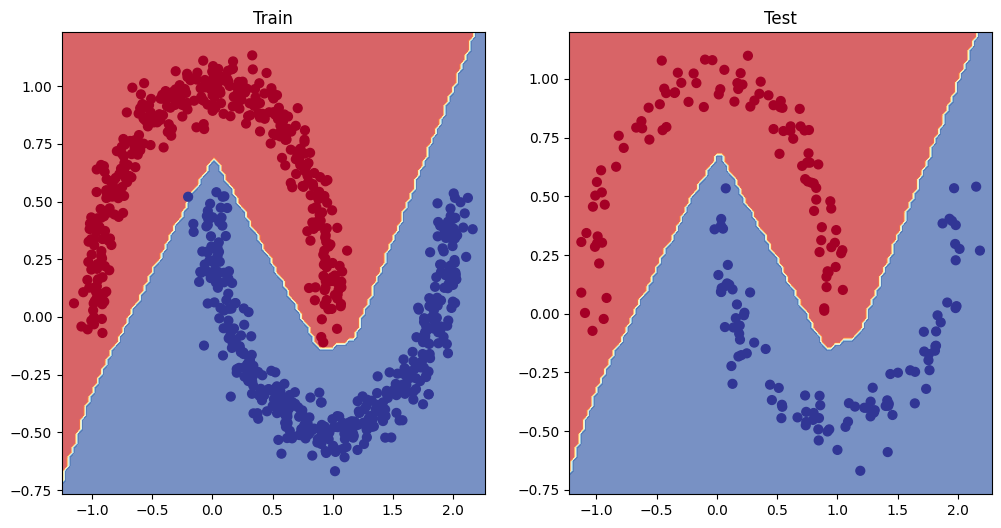

In [13]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### MULTI-CLASS CLASSIFICATION

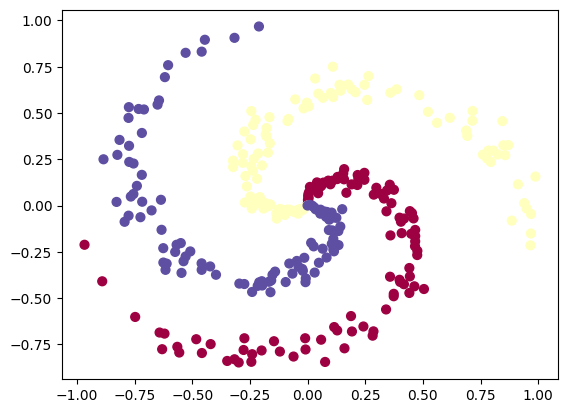

In [15]:
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [16]:
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
len(X_train), len(X_test), len(y_train), len(y_test)

(240, 60, 240, 60)

In [17]:
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device) # send accuracy function to device
acc_fn
     


MulticlassAccuracy()

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class SpiralModel(nn.Module): 
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(in_features=2, out_features=10)
    self.linear2 = nn.Linear(in_features=10, out_features=10)
    self.linear3 = nn.Linear(in_features=10, out_features=3)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))

model_1 = SpiralModel().to(device)
model_1

SpiralModel(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

In [19]:
# Setup data to be device agnostic
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)

# Print out untrained model outputs
print("Logits:")
print(model_1(X_train)[:10])

print("Pred probs:")
print(torch.softmax(model_1(X_train)[:10], dim=1))

print("Pred labels:")
print(torch.softmax(model_1(X_train)[:10], dim=1).argmax(dim=1))
     

torch.float32 torch.float32 torch.int64 torch.int64
Logits:
tensor([[-0.2181, -0.0617,  0.2245],
        [-0.2039, -0.0522,  0.2296],
        [-0.2229, -0.0609,  0.2383],
        [-0.2187, -0.0556,  0.2864],
        [-0.2195, -0.0477,  0.2766],
        [-0.2205, -0.0569,  0.2466],
        [-0.2205, -0.0578,  0.2434],
        [-0.2254, -0.0632,  0.2359],
        [-0.2057, -0.0530,  0.2298],
        [-0.2176, -0.0553,  0.2861]], grad_fn=<SliceBackward0>)
Pred probs:
tensor([[0.2684, 0.3138, 0.4178],
        [0.2698, 0.3140, 0.4162],
        [0.2658, 0.3126, 0.4216],
        [0.2608, 0.3070, 0.4322],
        [0.2611, 0.3101, 0.4288],
        [0.2650, 0.3121, 0.4228],
        [0.2655, 0.3124, 0.4222],
        [0.2658, 0.3126, 0.4216],
        [0.2695, 0.3140, 0.4166],
        [0.2610, 0.3070, 0.4320]], grad_fn=<SoftmaxBackward0>)
Pred labels:
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


In [20]:
## setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(),
                             lr = 0.1)

In [24]:
# Build a training loop for the model
epochs = 1000

# Loop over data
for epoch in range(epochs):
  ## Training
  model_1.train()
  # 1. forward pass
  y_logits = model_1(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train)
  
  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. loss backwards
  loss.backward()

  # 5. optimizer step step step
  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # 2. Caculate loss and acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.12 Acc: 0.32 | Test loss: 1.09 Test acc: 0.27
Epoch: 100 | Loss: 0.19 Acc: 0.94 | Test loss: 0.37 Test acc: 0.87
Epoch: 200 | Loss: 0.18 Acc: 0.94 | Test loss: 0.50 Test acc: 0.88
Epoch: 300 | Loss: 0.14 Acc: 0.95 | Test loss: 0.44 Test acc: 0.92
Epoch: 400 | Loss: 0.13 Acc: 0.95 | Test loss: 0.50 Test acc: 0.92
Epoch: 500 | Loss: 0.17 Acc: 0.95 | Test loss: 0.34 Test acc: 0.88
Epoch: 600 | Loss: 0.14 Acc: 0.95 | Test loss: 0.37 Test acc: 0.88
Epoch: 700 | Loss: 0.13 Acc: 0.95 | Test loss: 0.49 Test acc: 0.90
Epoch: 800 | Loss: 0.12 Acc: 0.95 | Test loss: 0.53 Test acc: 0.90
Epoch: 900 | Loss: 0.12 Acc: 0.95 | Test loss: 0.56 Test acc: 0.90


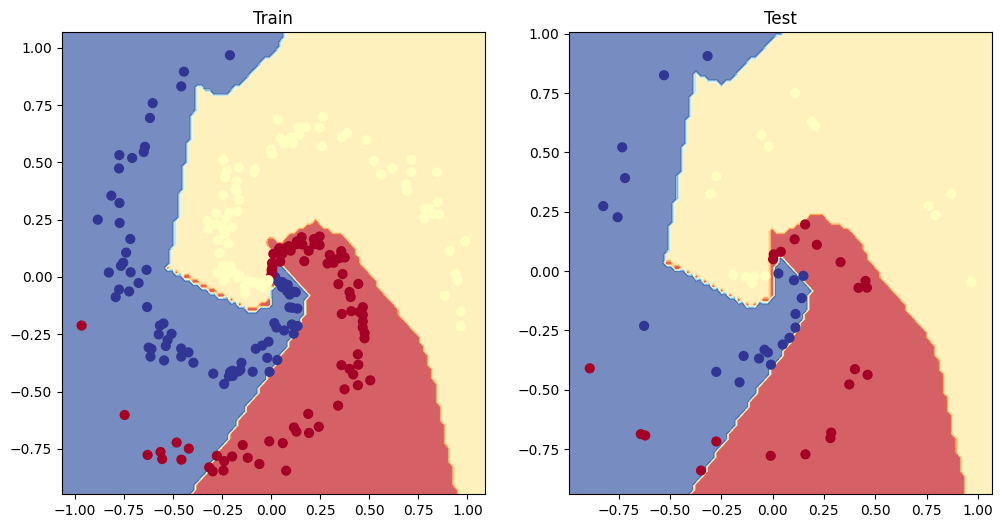

In [25]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)
     